# **Import Libraries**

In [ ]:
# For Preparing Data
import os
from zipfile import ZipFile
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator, load_img
import random

# For Building Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense

# For Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# For Prepare Training & Validating data
from sklearn.model_selection import train_test_split

# For Data Augmentation
from keras.preprocessing.image import ImageDataGenerator

import numpy as np

# For transfer learning
from keras import applications
from keras.models import Model
from keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout

# **Define Constants**

In [ ]:
# For Preparing Data
DATA_DIR = "../data"
TRAIN_DIR = "../data/train/"
TEST_DIR = "../data/test1/"

ZIP_TRAIN_DIR = "../input/dogs-vs-cats/train.zip"
ZIP_TEST_DIR = "../input/dogs-vs-cats/test1.zip"

# For Building Model
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_CHANNELS = 3

input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
# For Fitting Model
FAST_RUN = True

# 1. Categorize Input Data

Create a directory to unzip the training & testing data both in different directories. But first check if that directory already exists

Then unzip the data into its directory

In [ ]:
# check if the directories already exist then dont make them
if not os.path.exists(DATA_DIR):
    os.mkdir(DATA_DIR)
    
    with ZipFile(ZIP_TRAIN_DIR) as zf:
        zf.extractall(DATA_DIR)
    
    with ZipFile(ZIP_TEST_DIR) as zf:
        zf.extractall(DATA_DIR)

Have a look inside the folders we created

In [ ]:
for dirname, _, filenames in os.walk(DATA_DIR):
    for index, filename in enumerate(filenames):
        if index < 3:
            print(os.path.join(dirname, filename))
            
        else:
            print("** **")
            break

Now, let's prepare our training data into data frame

Giving a dog value of 1 and a cat value of 0

In [ ]:
train_files = os.listdir(TRAIN_DIR)
categories = []

for file in train_files:
    category = file.split('.')[0]
    
    if category == "dog":
        categories.append(1)
    else:
        categories.append(0)
        
df = pd.DataFrame({
    'filename': train_files,
    'category': categories
})

Have a look of the data frame

In [ ]:
df.head()

see the data charts of data frames

In [ ]:
df['category'].value_counts().plot.bar()

see a sample image

In [ ]:
# using PIL
img_path = os.path.join(TRAIN_DIR, random.choice(train_files))
img = Image.open(os.path.join(img_path))
display(img)

# using matplot
# img = load_img(img_path)
# plt.imshow(img)

# 2. Build Model

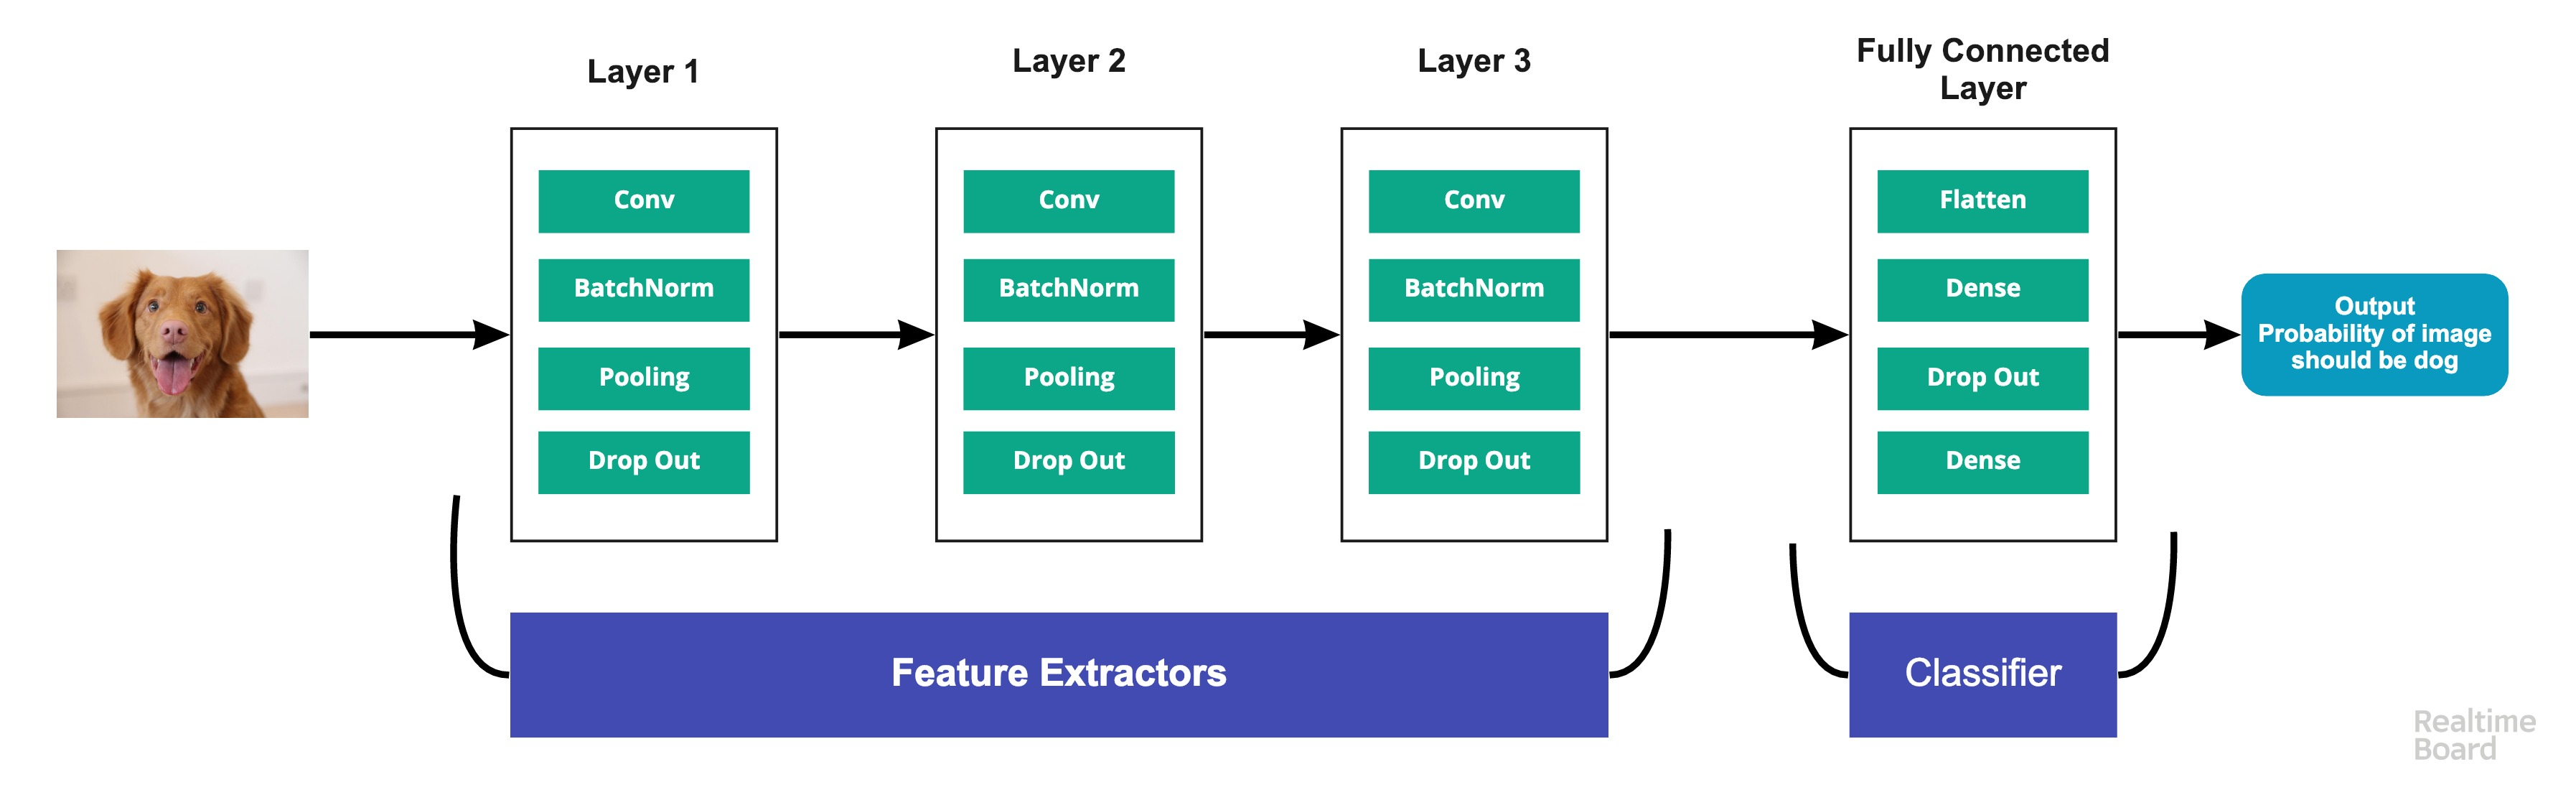

Input Layer: It represent input image data. It will reshape image into single diminsion array. Example your image is 64x64 = 4096, it will convert to (4096,1) array.

Conv Layer: This layer will extract features from image.

Pooling Layer: This layerreduce the spatial volume of input image after convolution.

Fully Connected Layer: It connect the network from a layer to another layer.

Output Layer: It is the predicted values layer.

In [ ]:
def add_FE_layer(model, num_filters, kernel_size, _activation, _input_shape, _pool_size, drop_rate):
    if _input_shape is None:
        model.add(Conv2D(num_filters, kernel_size, activation=_activation))
    else:
        model.add(Conv2D(num_filters, kernel_size, activation=_activation, input_shape=_input_shape))
        
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=_pool_size))
    model.add(Dropout(drop_rate))
    return model

model = Sequential()
model = add_FE_layer(model, 32, (3, 3), 'relu', input_shape, (2, 2), 0.25)
model = add_FE_layer(model, 64, (3, 3), 'relu', None, (2, 2), 0.25)
model = add_FE_layer(model, 128, (3, 3), 'relu', None, (2, 2), 0.25)

model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

# Callbacks 

**Early Stop**

To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

**Learning Rate Reduction**

We will reduce the learning rate when then accuracy not increase for 2 steps

In [ ]:
early_stop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            factor=0.5,
                                            patience=2,
                                            verbose=1,
                                            min_lr=0.00001)

callbacks = [early_stop, learning_rate_reduction]

# 3. Prepare Training & Validating data

Because we will use image genaretor `with class_mode="categorical"`. 
We need to convert column category into string. Then imagenerator will convert it one-hot encoding which is good for our classification.

So we will convert 1 to dog and 0 to cat

In [ ]:
df['category'] = df['category'].replace({0:'cat', 1:'dog'})
df.head()

Split the input data into training(80%) & validation(20%)

In [ ]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)

print("before reseting index\n\n", train_df)

# reseting index creates a new column with the old values for the index before reset
# so activating drop=True enables us to remove that column 'index' holding the prev index values
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [ ]:
print("After reseting index with drop=True\n")
train_df.head()

Note: Here is the output if we used drop=False

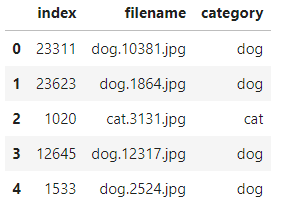

In [ ]:
train_df['category'].value_counts().plot.bar()

In [ ]:
validate_df['category'].value_counts().plot.bar()

define variables

In [ ]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size = 15

# 4. Data Augmentation

**Training Generator**

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    TRAIN_DIR,
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    class_mode='categorical',
    batch_size=batch_size
    
)

**Validation Generator**

In [ ]:
validate_datagen = ImageDataGenerator(rescale=1./255)

validate_generator = validate_datagen.flow_from_dataframe(
    validate_df,
    TRAIN_DIR,
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    class_mode='categorical',
    batch_size=batch_size
)

**Try the generator**

In [ ]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    TRAIN_DIR,
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    class_mode='categorical',
)

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# 5. Train model

In [ ]:
_epochs = 15 if FAST_RUN else 50
history = model.fit(
    train_generator,
    epochs=_epochs,
    validation_data=validate_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

# 6. Save Weights

In [ ]:
model.save_weights("weights.h5")

# 7. Virtualize Training

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, _epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, _epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# 8. Prepare Testing Data

In [ ]:
test_filenames = os.listdir(TEST_DIR)
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

**Create Testing Generator**

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator =  test_datagen.flow_from_dataframe(
    test_df,
    TEST_DIR,
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=batch_size,
    shuffle=False
)

# 9. Predict

In [ ]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

For categoral classication the prediction will come with probability of each category. So we will pick the category that have the highest probability with numpy average max

In [ ]:
test_df['category'] = np.argmax(predict, axis=-1)

We will convert the predict category back into our generator classes by using `train_generator.class_indices`. It is the classes that image generator map while converting data into computer vision

In [ ]:
lable_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(lable_map)

From our prepare data part. We map data with {1: 'dog', 0: 'cat'}. Now we will map the result back to dog is 1 and cat is 0

In [ ]:
test_df['category'] = test_df['category'].replace({'dog': 1, 'cat': 0})

# 10. Virtualize Result

In [ ]:
test_df['category'].value_counts().plot.bar()

**See predicted result with images**

In [ ]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img(TEST_DIR+filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

**Submission**

In [ ]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)

# 11. Transfer Learning

There are two different Transfer Learning approaches;

* Feature Extractor
* Fine Tunning

**11.1. Fearure Extractor**

We will use VGG16 with imagenet weights

<center>
    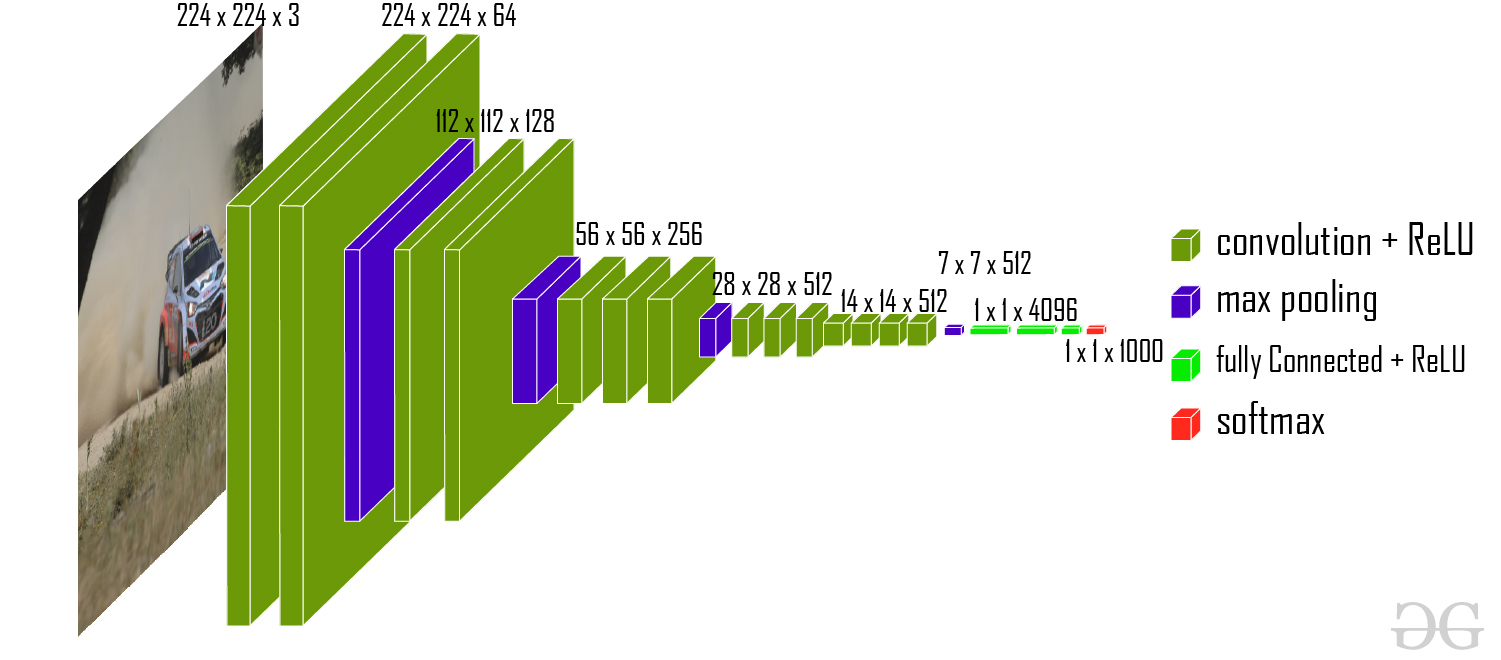
</center>

**11.1.1. load VGG16 model**

In [ ]:
base_model = applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

notice that the last layers in the above architecture **are not included** in the below summary as we have set the parameter include_top to false

In [ ]:
base_model.summary()

Now, we need to freeze all the layers so that their parameters won't be changed during training.

In [ ]:
for layer in base_model.layers:
    layer.trainable = False;

Start adding the final classifying layers that we want to train on the new dataset

**11.1.1. Build Classifier**


In [ ]:
m = base_model.layers[-1].output
m = GlobalAveragePooling2D()(m)
m = Dense(100, activation='relu')(m)
m = Dropout(0.4)(m)
m = Dense(64, activation='relu')(m)
m = Dense(2, activation='softmax')(m)

transfer_model = Model(base_model.input, m);
transfer_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
transfer_model.summary()

**11.1.3. Train Model**


Now let's train our new model

In [ ]:
t_epochs = 15 if FAST_RUN else 50
transfer_history = transfer_model.fit(    
    train_generator,
    epochs=t_epochs,
    validation_data=validate_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

**11.1.4. Save Weights**


In [ ]:
transfer_model.save_weights("vgg16_transfer_FE_weights.h5");

**11.1.5. Virtualize Training**

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(transfer_history.history['loss'], color='b', label="Training loss")
ax1.plot(transfer_history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, t_epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(transfer_history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(transfer_history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, t_epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

**11.1.6. Predict**

In [ ]:
transfer_predict = transfer_model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

In [ ]:
test_df['category'] = np.argmax(transfer_predict, axis=-1)
lable_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(lable_map)
test_df['category'] = test_df['category'].replace({'dog': 1, 'cat': 0})
test_df['category'].value_counts().plot.bar()

In [ ]:
sample_test = test_df.head(50)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img(TEST_DIR+filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
    plt.subplot(10, 5, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

# References:
Notebook: [link](https://www.kaggle.com/code/uysimty/keras-cnn-dog-or-cat-classification/notebook)

Creating a model: [link](https://pyimagesearch.com/2019/10/28/3-ways-to-create-a-keras-model-with-tensorflow-2-0-sequential-functional-and-model-subclassing/)

Cross Entropy Loss Functions: [link1](https://vitalflux.com/keras-categorical-cross-entropy-loss-function/) [link2](https://peltarion.com/knowledge-center/documentation/modeling-view/build-an-ai-model/loss-functions/categorical-crossentropy)

Early Stopping: [link](https://keras.io/api/callbacks/early_stopping/)

Reduce Learning Rate: [link](https://keras.io/api/callbacks/reduce_lr_on_plateau/)

sklearn.model_selection.train_test_split: [link](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

pandas.DataFrame.reset_index: [link](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reset_index.html)

tf.keras.preprocessing.image.ImageDataGenerato: [link](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

keras.fit() vs keras.fit_generator(): [link1](https://pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/) [link2](https://www.geeksforgeeks.org/keras-fit-and-keras-fit_generator/)

Transfer Learning: 
[documentation](https://www.tensorflow.org/tutorials/images/transfer_learning) 
[blog](https://www.v7labs.com/blog/transfer-learning-guide) 
[notebook](https://www.kaggle.com/code/mustafacicek/dogs-cats-vgg16-implementation-transfer-learning#5\)-Pre-Trained-VGG-16-Model-&-Transfer-Learning)